# Inception Model

## El modelo

El modelo Inception v3 tarda semanas en entrenarse en un computador con 8 GPUs Tesla K40, el cual probablemente cuesta $ 30,000 por lo que es imposible entrenarlo en una PC normal. En su lugar, descargamos el modelo de Inception pre-entrenado y lo usamos para clasificar las imágenes.

El modelo Inception v3 tiene casi 25 millones de parámetros y utiliza 5 mil millones de operaciones multiplicativas para clasificar una sola imagen. En un PC moderno sin una GPU esto puede hacerse en una fracción de segundo por imagen.


## Flowchart

El gráfico siguiente muestra cómo fluyen los datos en el modelo Inception v3, que es una red neuronal convolucional con muchas capas y una estructura complicada. El [artículo](http://arxiv.org/pdf/1512.00567v3.pdf) da más detalles sobre cómo se construye el modelo Inception y por qué está diseñado de esa manera. Pero los autores admiten que no entienden completamente por qué funciona.

El modelo Inception tiene dos salidas softmax. Uno se utiliza durante el entrenamiento de la red neuronal y el otro se utiliza para clasificar las imágenes después del entrenamiento ha terminado, también conocido como inferencia.

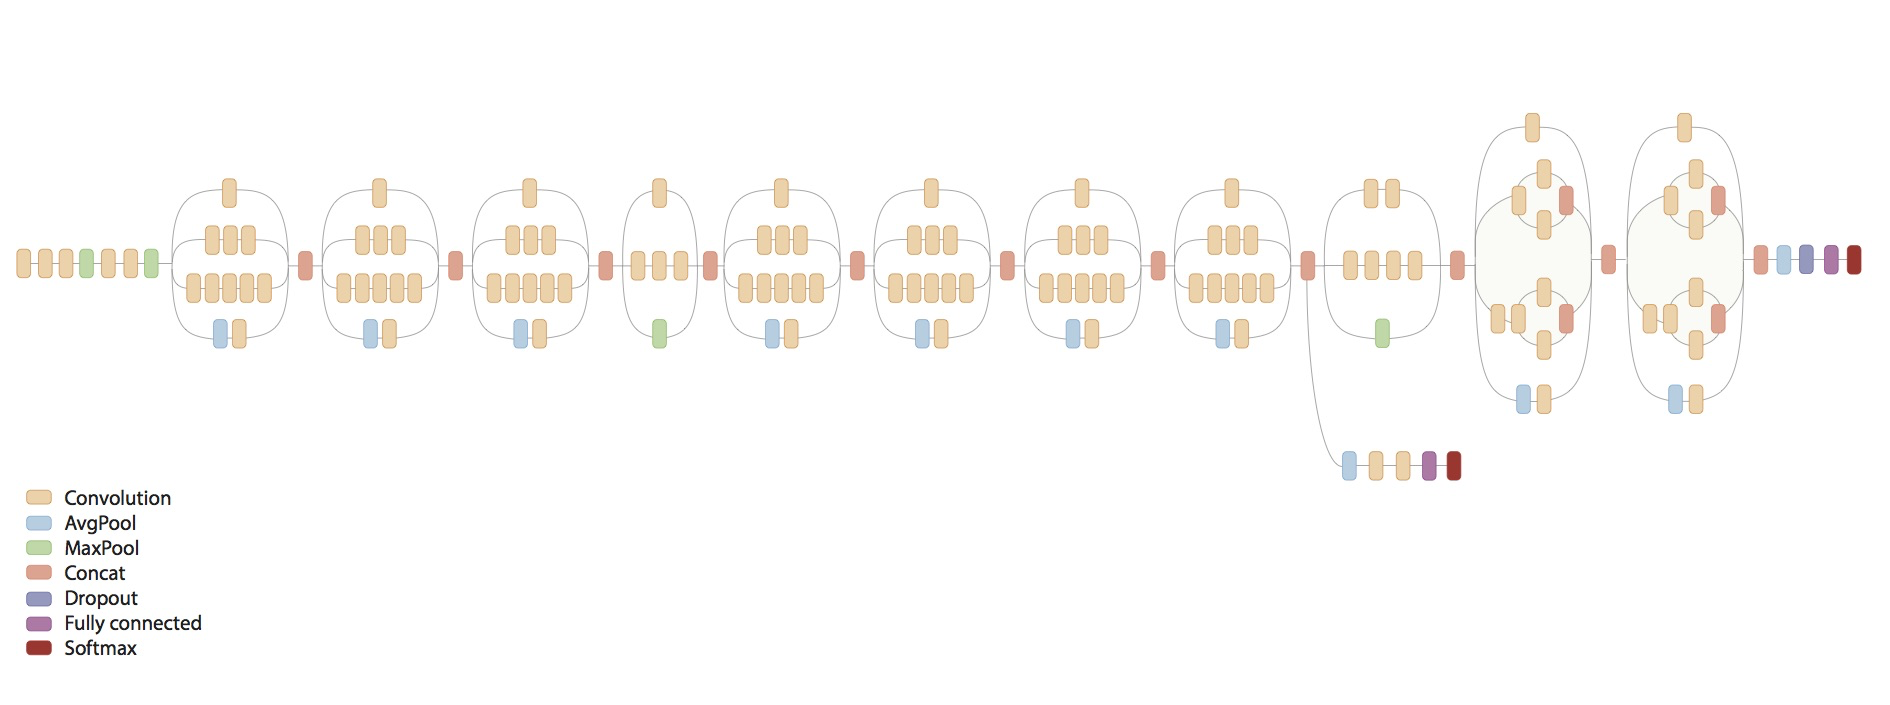

In [22]:
from IPython.display import Image, display
Image('images/07_inception_flowchart.png')

## Imports

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Functions and classes for loading and using the Inception model.
#import inception

import numpy as np
import tensorflow as tf
import download
from cache import cache
import os
import sys


This was developed using Python 3.5.2 (Anaconda) and TensorFlow version:

In [24]:
tf.__version__

'1.3.0'

In [25]:
########################################################################
# Various directories and file-names.

# Internet URL for the tar-file with the Inception model.
# Note that this might change in the future and will need to be updated.
data_url = "http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz"

# Directory to store the downloaded data.
data_dir = "inception/"

# File containing the mappings between class-number and uid. (Downloaded)
path_uid_to_cls = "imagenet_2012_challenge_label_map_proto.pbtxt"

# File containing the mappings between uid and string. (Downloaded)
path_uid_to_name = "imagenet_synset_to_human_label_map.txt"

# File containing the TensorFlow graph definition. (Downloaded)
path_graph_def = "classify_image_graph_def.pb"

########################################################################

In [26]:
def maybe_download():
    """
    Download the Inception model from the internet if it does not already
    exist in the data_dir. The file is about 85 MB.
    """

    print("Downloading Inception v3 Model ...")
    download.maybe_download_and_extract(url=data_url, download_dir=data_dir)


########################################################################

In [27]:
class NameLookup:
    """
    Used for looking up the name associated with a class-number.
    This is used to print the name of a class instead of its number,
    e.g. "plant" or "horse".

    Maps between:
    - cls is the class-number as an integer between 1 and 1000 (inclusive).
    - uid is a class-id as a string from the ImageNet data-set, e.g. "n00017222".
    - name is the class-name as a string, e.g. "plant, flora, plant life"

    There are actually 1008 output classes of the Inception model
    but there are only 1000 named classes in these mapping-files.
    The remaining 8 output classes of the model should not be used.
    """

    def __init__(self):
        # Mappings between uid, cls and name are dicts, where insertions and
        # lookup have O(1) time-usage on average, but may be O(n) in worst case.
        self._uid_to_cls = {}   # Map from uid to cls.
        self._uid_to_name = {}  # Map from uid to name.
        self._cls_to_uid = {}   # Map from cls to uid.

        # Read the uid-to-name mappings from file.
        path = os.path.join(data_dir, path_uid_to_name)
        with open(file=path, mode='r') as file:
            # Read all lines from the file.
            lines = file.readlines()

            for line in lines:
                # Remove newlines.
                line = line.replace("\n", "")

                # Split the line on tabs.
                elements = line.split("\t")

                # Get the uid.
                uid = elements[0]

                # Get the class-name.
                name = elements[1]

                # Insert into the lookup-dict.
                self._uid_to_name[uid] = name

        # Read the uid-to-cls mappings from file.
        path = os.path.join(data_dir, path_uid_to_cls)
        with open(file=path, mode='r') as file:
            # Read all lines from the file.
            lines = file.readlines()

            for line in lines:
                # We assume the file is in the proper format,
                # so the following lines come in pairs. Other lines are ignored.

                if line.startswith("  target_class: "):
                    # This line must be the class-number as an integer.

                    # Split the line.
                    elements = line.split(": ")

                    # Get the class-number as an integer.
                    cls = int(elements[1])

                elif line.startswith("  target_class_string: "):
                    # This line must be the uid as a string.

                    # Split the line.
                    elements = line.split(": ")

                    # Get the uid as a string e.g. "n01494475"
                    uid = elements[1]

                    # Remove the enclosing "" from the string.
                    uid = uid[1:-2]

                    # Insert into the lookup-dicts for both ways between uid and cls.
                    self._uid_to_cls[uid] = cls
                    self._cls_to_uid[cls] = uid

    def uid_to_cls(self, uid):
        """
        Return the class-number as an integer for the given uid-string.
        """

        return self._uid_to_cls[uid]

    def uid_to_name(self, uid, only_first_name=False):
        """
        Return the class-name for the given uid string.

        Some class-names are lists of names, if you only want the first name,
        then set only_first_name=True.
        """

        # Lookup the name from the uid.
        name = self._uid_to_name[uid]

        # Only use the first name in the list?
        if only_first_name:
            name = name.split(",")[0]

        return name

    def cls_to_name(self, cls, only_first_name=False):
        """
        Return the class-name from the integer class-number.

        Some class-names are lists of names, if you only want the first name,
        then set only_first_name=True.
        """

        # Lookup the uid from the cls.
        uid = self._cls_to_uid[cls]

        # Lookup the name from the uid.
        name = self.uid_to_name(uid=uid, only_first_name=only_first_name)

        return name


########################################################################

In [28]:
class Inception:
    """
    The Inception model is a Deep Neural Network which has already been
    trained for classifying images into 1000 different categories.

    When you create a new instance of this class, the Inception model
    will be loaded and can be used immediately without training.

    The Inception model can also be used for Transfer Learning.
    """

    # Name of the tensor for feeding the input image as jpeg.
    tensor_name_input_jpeg = "DecodeJpeg/contents:0"

    # Name of the tensor for feeding the decoded input image.
    # Use this for feeding images in other formats than jpeg.
    tensor_name_input_image = "DecodeJpeg:0"

    # Name of the tensor for the resized input image.
    # This is used to retrieve the image after it has been resized.
    tensor_name_resized_image = "ResizeBilinear:0"

    # Name of the tensor for the output of the softmax-classifier.
    # This is used for classifying images with the Inception model.
    tensor_name_softmax = "softmax:0"

    # Name of the tensor for the unscaled outputs of the softmax-classifier (aka. logits).
    tensor_name_softmax_logits = "softmax/logits:0"

    # Name of the tensor for the output of the Inception model.
    # This is used for Transfer Learning.
    tensor_name_transfer_layer = "pool_3:0"

    def __init__(self):
        # Mappings between class-numbers and class-names.
        # Used to print the class-name as a string e.g. "horse" or "plant".
        self.name_lookup = NameLookup()

        # Now load the Inception model from file. The way TensorFlow
        # does this is confusing and requires several steps.

        # Create a new TensorFlow computational graph.
        self.graph = tf.Graph()

        # Set the new graph as the default.
        with self.graph.as_default():

            # TensorFlow graphs are saved to disk as so-called Protocol Buffers
            # aka. proto-bufs which is a file-format that works on multiple
            # platforms. In this case it is saved as a binary file.

            # Open the graph-def file for binary reading.
            path = os.path.join(data_dir, path_graph_def)
            with tf.gfile.FastGFile(path, 'rb') as file:
                # The graph-def is a saved copy of a TensorFlow graph.
                # First we need to create an empty graph-def.
                graph_def = tf.GraphDef()

                # Then we load the proto-buf file into the graph-def.
                graph_def.ParseFromString(file.read())

                # Finally we import the graph-def to the default TensorFlow graph.
                tf.import_graph_def(graph_def, name='')

                # Now self.graph holds the Inception model from the proto-buf file.

        # Get the output of the Inception model by looking up the tensor
        # with the appropriate name for the output of the softmax-classifier.
        self.y_pred = self.graph.get_tensor_by_name(self.tensor_name_softmax)

        # Get the unscaled outputs for the Inception model (aka. softmax-logits).
        self.y_logits = self.graph.get_tensor_by_name(self.tensor_name_softmax_logits)

        # Get the tensor for the resized image that is input to the neural network.
        self.resized_image = self.graph.get_tensor_by_name(self.tensor_name_resized_image)

        # Get the tensor for the last layer of the graph, aka. the transfer-layer.
        self.transfer_layer = self.graph.get_tensor_by_name(self.tensor_name_transfer_layer)

        # Get the number of elements in the transfer-layer.
        self.transfer_len = self.transfer_layer.get_shape()[3]

        # Create a TensorFlow session for executing the graph.
        self.session = tf.Session(graph=self.graph)

    def close(self):
        """
        Call this function when you are done using the Inception model.
        It closes the TensorFlow session to release its resources.
        """

        self.session.close()

    def _write_summary(self, logdir='summary/'):
        """
        Write graph to summary-file so it can be shown in TensorBoard.

        This function is used for debugging and may be changed or removed in the future.

        :param logdir:
            Directory for writing the summary-files.

        :return:
            Nothing.
        """

        writer = tf.train.SummaryWriter(logdir=logdir, graph=self.graph)
        writer.close()

    def _create_feed_dict(self, image_path=None, image=None):
        """
        Create and return a feed-dict with an image.

        :param image_path:
            The input image is a jpeg-file with this file-path.

        :param image:
            The input image is a 3-dim array which is already decoded.
            The pixels MUST be values between 0 and 255 (float or int).

        :return:
            Dict for feeding to the Inception graph in TensorFlow.
        """

        if image is not None:
            # Image is passed in as a 3-dim array that is already decoded.
            feed_dict = {self.tensor_name_input_image: image}

        elif image_path is not None:
            # Read the jpeg-image as an array of bytes.
            image_data = tf.gfile.FastGFile(image_path, 'rb').read()

            # Image is passed in as a jpeg-encoded image.
            feed_dict = {self.tensor_name_input_jpeg: image_data}

        else:
            raise ValueError("Either image or image_path must be set.")

        return feed_dict

    def classify(self, image_path=None, image=None):
        """
        Use the Inception model to classify a single image.

        The image will be resized automatically to 299 x 299 pixels,
        see the discussion in the Python Notebook for Tutorial #07.

        :param image_path:
            The input image is a jpeg-file with this file-path.

        :param image:
            The input image is a 3-dim array which is already decoded.
            The pixels MUST be values between 0 and 255 (float or int).

        :return:
            Array of floats (aka. softmax-array) indicating how likely
            the Inception model thinks the image is of each given class.
        """

        # Create a feed-dict for the TensorFlow graph with the input image.
        feed_dict = self._create_feed_dict(image_path=image_path, image=image)

        # Execute the TensorFlow session to get the predicted labels.
        pred = self.session.run(self.y_pred, feed_dict=feed_dict)

        # Reduce the array to a single dimension.
        pred = np.squeeze(pred)

        return pred

    def get_resized_image(self, image_path=None, image=None):
        """
        Input an image to the Inception model and return
        the resized image. The resized image can be plotted so
        we can see what the neural network sees as its input.

        :param image_path:
            The input image is a jpeg-file with this file-path.

        :param image:
            The input image is a 3-dim array which is already decoded.
            The pixels MUST be values between 0 and 255 (float or int).

        :return:
            A 3-dim array holding the image.
        """

        # Create a feed-dict for the TensorFlow graph with the input image.
        feed_dict = self._create_feed_dict(image_path=image_path, image=image)

        # Execute the TensorFlow session to get the predicted labels.
        resized_image = self.session.run(self.resized_image, feed_dict=feed_dict)

        # Remove the 1st dimension of the 4-dim tensor.
        resized_image = resized_image.squeeze(axis=0)

        # Scale pixels to be between 0.0 and 1.0
        resized_image = resized_image.astype(float) / 255.0

        return resized_image

    def print_scores(self, pred, k=10, only_first_name=True):
        """
        Print the scores (or probabilities) for the top-k predicted classes.

        :param pred:
            Predicted class-labels returned from the predict() function.

        :param k:
            How many classes to print.

        :param only_first_name:
            Some class-names are lists of names, if you only want the first name,
            then set only_first_name=True.

        :return:
            Nothing.
        """

        # Get a sorted index for the pred-array.
        idx = pred.argsort()

        # The index is sorted lowest-to-highest values. Take the last k.
        top_k = idx[-k:]

        # Iterate the top-k classes in reversed order (i.e. highest first).
        for cls in reversed(top_k):
            # Lookup the class-name.
            name = self.name_lookup.cls_to_name(cls=cls, only_first_name=only_first_name)

            # Predicted score (or probability) for this class.
            score = pred[cls]

            # Print the score and class-name.
            print("{0:>6.2%} : {1}".format(score, name))

    def transfer_values(self, image_path=None, image=None):
        """
        Calculate the transfer-values for the given image.
        These are the values of the last layer of the Inception model before
        the softmax-layer, when inputting the image to the Inception model.

        The transfer-values allow us to use the Inception model in so-called
        Transfer Learning for other data-sets and different classifications.

        It may take several hours or more to calculate the transfer-values
        for all images in a data-set. It is therefore useful to cache the
        results using the function transfer_values_cache() below.

        :param image_path:
            The input image is a jpeg-file with this file-path.

        :param image:
            The input image is a 3-dim array which is already decoded.
            The pixels MUST be values between 0 and 255 (float or int).

        :return:
            The transfer-values for those images.
        """

        # Create a feed-dict for the TensorFlow graph with the input image.
        feed_dict = self._create_feed_dict(image_path=image_path, image=image)

        # Use TensorFlow to run the graph for the Inception model.
        # This calculates the values for the last layer of the Inception model
        # prior to the softmax-classification, which we call transfer-values.
        transfer_values = self.session.run(self.transfer_layer, feed_dict=feed_dict)

        # Reduce to a 1-dim array.
        transfer_values = np.squeeze(transfer_values)

        return transfer_values

In [29]:
# Batch-processing.

def process_images(fn, images=None, image_paths=None):
    """
    Call the function fn() for each image, e.g. transfer_values() from
    the Inception model above. All the results are concatenated and returned.

    :param fn:
        Function to be called for each image.

    :param images:
        List of images to process.

    :param image_paths:
        List of file-paths for the images to process.

    :return:
        Numpy array with the results.
    """

    # Are we using images or image_paths?
    using_images = images is not None

    # Number of images.
    if using_images:
        num_images = len(images)
    else:
        num_images = len(image_paths)

    # Pre-allocate list for the results.
    # This holds references to other arrays. Initially the references are None.
    result = [None] * num_images

    # For each input image.
    for i in range(num_images):
        # Status-message. Note the \r which means the line should overwrite itself.
        msg = "\r- Processing image: {0:>6} / {1}".format(i+1, num_images)

        # Print the status message.
        sys.stdout.write(msg)
        sys.stdout.flush()

        # Process the image and store the result for later use.
        if using_images:
            result[i] = fn(image=images[i])
        else:
            result[i] = fn(image_path=image_paths[i])

    # Print newline.
    print()

    # Convert the result to a numpy array.
    result = np.array(result)

    return result


########################################################################

In [30]:
def transfer_values_cache(cache_path, model, images=None, image_paths=None):
    """
    This function either loads the transfer-values if they have
    already been calculated, otherwise it calculates the values
    and saves them to a file that can be re-loaded again later.

    Because the transfer-values can be expensive to compute, it can
    be useful to cache the values through this function instead
    of calling transfer_values() directly on the Inception model.

    See Tutorial #08 for an example on how to use this function.

    :param cache_path:
        File containing the cached transfer-values for the images.

    :param model:
        Instance of the Inception model.

    :param images:
        4-dim array with images. [image_number, height, width, colour_channel]

    :param image_paths:
        Array of file-paths for images (must be jpeg-format).

    :return:
        The transfer-values from the Inception model for those images.
    """

    # Helper-function for processing the images if the cache-file does not exist.
    # This is needed because we cannot supply both fn=process_images
    # and fn=model.transfer_values to the cache()-function.
    def fn():
        return process_images(fn=model.transfer_values, images=images, image_paths=image_paths)

    # Read the transfer-values from a cache-file, or calculate them if the file does not exist.
    transfer_values = cache(cache_path=cache_path, fn=fn)

    return transfer_values


## Download the Inception Model

The Inception model is downloaded from the internet. This is the default directory where you want to save the data-files. The directory will be created if it does not exist.

In [31]:
# inception.data_dir = 'inception/'

Download the data for the Inception model if it doesn't already exist in the directory. It is 85 MB.

In [32]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


## Load the Inception Model

Load the Inception model so it is ready for classifying images.

In [33]:
model = inception.Inception()

## Helper-function for classifying and plotting images

This is a simple wrapper-function for displaying the image, then classifying it using the Inception model and finally printing the classification scores.

In [34]:
def classify(image_path):
    # Display the image.
    display(Image(image_path))

    # Use the Inception model to classify the image.
    pred = model.classify(image_path=image_path)

    # Print the scores and names for the top-10 predictions.
    model.print_scores(pred=pred, k=10, only_first_name=True)    

## Panda

This image of a panda is included in the Inception data-file. The Inception model is quite confident that this image shows a panda, with a classification score of about 89% and the next highest score being only about 0.8% for an indri, which is another exotic animal.

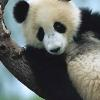

89.11% : giant panda
 0.78% : indri
 0.30% : lesser panda
 0.15% : custard apple
 0.12% : earthstar
 0.09% : sea urchin
 0.05% : forklift
 0.05% : digital watch
 0.05% : gibbon
 0.05% : go-kart


In [35]:
image_path = os.path.join(inception.data_dir, 'cropped_panda.jpg')
classify(image_path)

## Interpretation of Classification Scores

The output of the Inception model is a so-called Softmax-function which was also used in the neural networks in the previous tutorials.

The softmax-outputs are sometimes called probabilities because they are between zero and one, and they also sum to one - just like probabilities. But they are actually not probabilities in the traditional sense of the word, because they do not come from repeated experiments.

It is perhaps better to call the output values of a neural network for classification scores or ranks, because they indicate how strongly the network believes that the input image is of each possible class.

In the above example with the image of a panda, the Inception model gave a very high score of about 89% for the panda-class, and the scores for the remaining 999 possible classes were all below 1%. This means the Inception model was quite certain that the image showed a panda and the remaining scores below 1% should be regarded as noise. For example, the 8th highest score was 0.05% for a digital watch, but this is probably more due to the imprecise nature of neural networks rather than an indication that the image looked slightly like a digital watch.

Sometimes the Inception model is confused about which class an image belongs to, so none of the scores are really high. Examples of this are shown below.

## Parrot (Original Image)

The Inception model is very confident (score about 97%) that this image shows a kind of parrot called a macaw.

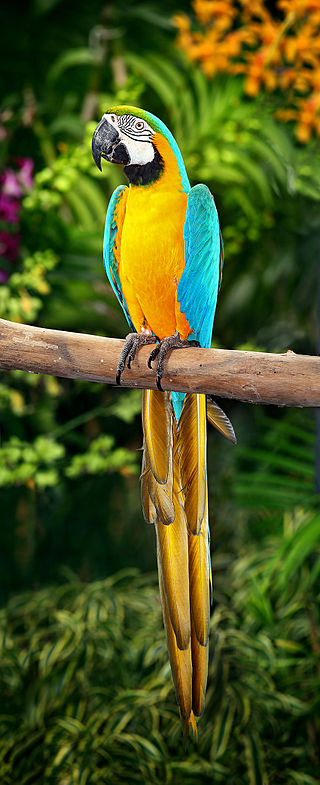

97.18% : macaw
 0.07% : African grey
 0.06% : toucan
 0.05% : jacamar
 0.04% : bee eater
 0.03% : lorikeet
 0.02% : sulphur-crested cockatoo
 0.02% : jay
 0.01% : kite
 0.01% : indigo bunting


In [36]:
classify(image_path="images/parrot.jpg")

## Parrot (Resized Image)

The Inception model works on input images that are 299 x 299 pixels in size. The above image of a parrot is actually 320 pixels wide and 785 pixels high, so it is resized automatically by the Inception model.

We now want to see the image after it has been resized by the Inception model.

First we have a helper-function for getting the resized image from inside the Inception model.

In [37]:
def plot_resized_image(image_path):
    # Get the resized image from the Inception model.
    resized_image = model.get_resized_image(image_path=image_path)

    # Plot the image.
    plt.imshow(resized_image, interpolation='nearest')
    
    # Ensure that the plot is shown.
    plt.show()

Now plot the resized image of the parrot. This is the image that is actually input to the neural network of the Inception model. We can see that it has been squeezed so it is square, and the resolution has been reduced so the image has become more pixelated and grainy.

In this case the image still clearly shows a parrot, but some images may become so distorted from this naive resizing that you may want to resize the images yourself before inputting them to the Inception model.

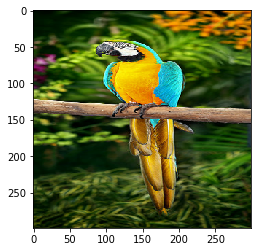

In [38]:
plot_resized_image(image_path="images/parrot.jpg")

## Parrot (Cropped Image, Top)

This image of the parrot has been cropped manually to 299 x 299 pixels and then input to the Inception model, which is still very confident (score about 97%) that it shows a parrot (macaw).

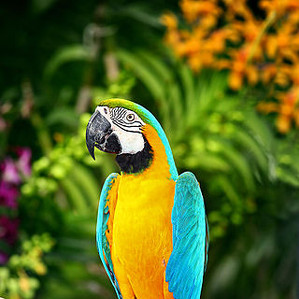

97.52% : macaw
 0.09% : African grey
 0.03% : sulphur-crested cockatoo
 0.02% : toucan
 0.02% : reflex camera
 0.01% : comic book
 0.01% : backpack
 0.01% : bib
 0.01% : vulture
 0.01% : lens cap


In [39]:
classify(image_path="images/parrot_cropped1.jpg")

## Parrot (Cropped Image, Middle)

This is another crop of the parrot image, this time showing its body without the head or tail. The Inception model is still very confident (score about 94%) that it shows a macaw parrot.

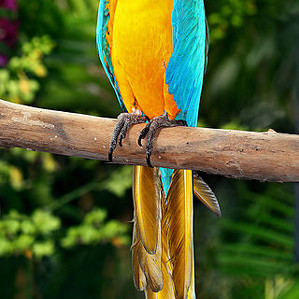

94.21% : macaw
 0.76% : toucan
 0.58% : African grey
 0.11% : jacamar
 0.10% : sulphur-crested cockatoo
 0.10% : bee eater
 0.09% : magpie
 0.08% : jay
 0.06% : lorikeet
 0.04% : hornbill


In [40]:
classify(image_path="images/parrot_cropped2.jpg")

## Parrot (Cropped Image, Bottom)

This image has been cropped so it only shows the tail of the parrot. Now the Inception model is quite confused and thinks the image might show a jacamar (score about 26%) which is another exotic bird, or perhaps the image shows a grass-hopper (score about 10%).

The Inception model also thinks the image might show a fountain-pen (score about 2%). But this is a very low score and should be interpreted as unreliable noise.

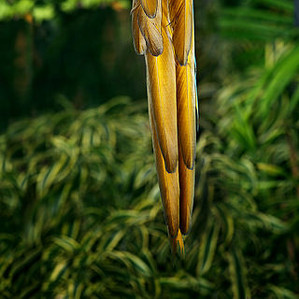

26.51% : jacamar
10.56% : grasshopper
 3.58% : chime
 2.15% : bulbul
 1.93% : fountain pen
 1.64% : leafhopper
 1.31% : kite
 1.22% : cricket
 1.09% : macaw
 0.81% : bee eater


In [41]:
classify(image_path="images/parrot_cropped3.jpg")

## Parrot (Padded Image)

The best way to input images to this Inception model, is to pad the image so it is square and then resize the image to 299 x 299 pixels, like this example of the parrot which is classified correctly with a score of about 97%.

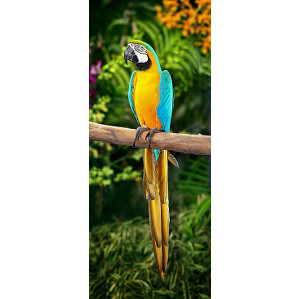

96.87% : macaw
 0.06% : African grey
 0.06% : toucan
 0.05% : bee eater
 0.04% : sulphur-crested cockatoo
 0.03% : king penguin
 0.03% : jacamar
 0.03% : lorikeet
 0.01% : kite
 0.01% : anemone fish


In [42]:
classify(image_path="images/parrot_padded.jpg")

## Elon Musk (299 x 299 pixels)

This image shows the living legend and super-nerd-hero Elon Musk. But the Inception model is very confused about what the image shows, predicting that it maybe shows a sweatshirt (score about 17%) or an abaya (score about 16%). It also thinks the image might show a ping-pong ball (score about 3%) or a baseball (score about 2%). So the Inception model is confused and the classification scores are unreliable.

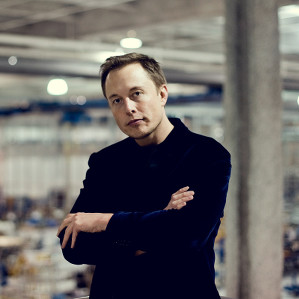

16.63% : sweatshirt
16.45% : abaya
 4.62% : suit
 3.40% : ping-pong ball
 2.89% : trench coat
 2.37% : baseball
 2.31% : cellular telephone
 1.99% : jersey
 1.42% : water bottle
 1.34% : dumbbell


In [43]:
classify(image_path="images/elon_musk.jpg")

## Elon Musk (100 x 100 pixels)

If we instead use a 100 x 100 pixels image of Elon Musk, then the Inception model thinks it might show a sweatshirt (score about 22%) or a cowboy boot (score about 14%). So now the Inception model has somewhat different predictions but it is still very confused.

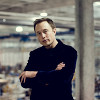

21.65% : sweatshirt
14.51% : cowboy boot
 9.11% : abaya
 8.70% : balance beam
 5.92% : suit
 5.65% : Loafer
 3.66% : trench coat
 1.75% : maillot
 1.44% : jersey
 1.44% : unicycle


In [44]:
classify(image_path="images/elon_musk_100x100.jpg")

The Inception model automatically upscales this image from 100 x 100 to 299 x 299 pixels, which is shown here. Note how pixelated and grainy it really is, although a human can easily see that this is a picture of a man with crossed arms.

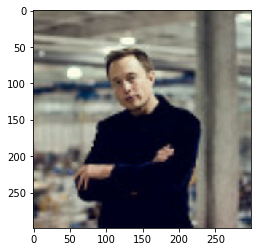

In [45]:
plot_resized_image(image_path="images/elon_musk_100x100.jpg")

## Willy Wonka (Gene Wilder)

This image shows the actor Gene Wilder portraying Willy Wonka in the 1971 version of the movie. The Inception model is very confident that the image shows a bow tie (score about 98%), which is true but a human would probably say this image shows a person.

The reason might be that the Inception model was trained on images of people with bow-ties that were classified as a bow-tie rather than a person. So maybe the problem is that the class-name should be "person with bow-tie" instead of just "bow-tie".

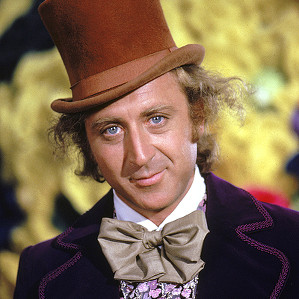

97.98% : bow tie
 0.63% : cowboy hat
 0.14% : sombrero
 0.07% : suit
 0.05% : bolo tie
 0.04% : Windsor tie
 0.03% : cornet
 0.02% : flute
 0.02% : banjo
 0.01% : revolver


In [46]:
classify(image_path="images/willy_wonka_old.jpg")

## Willy Wonka (Johnny Depp)

This image shows the actor Johnny Depp portraying Willy Wonka in the 2005 version of the movie. The Inception model thinks that this image shows "sunglasses" (score about 34%) or "sunglass" (score about 18%). Actually, the full name of the first class is "sunglasses, dark glasses, shades". For some reason the Inception model has been trained to recognize two very similar classes for sunglasses. Once again, it is correct that the image shows sunglasses, but a human would probably have said that this image shows a person.

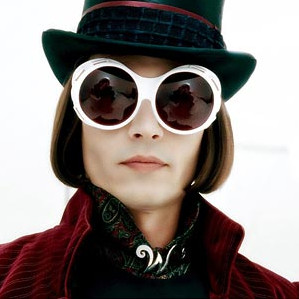

34.47% : sunglasses
18.10% : sunglass
 1.29% : velvet
 0.95% : wig
 0.85% : cowboy hat
 0.72% : sombrero
 0.64% : seat belt
 0.50% : jean
 0.44% : stole
 0.41% : poncho


In [47]:
classify(image_path="images/willy_wonka_new.jpg")

## Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources. Note that the TensorFlow-session is inside the model-object, so we close the session through that object.

In [48]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# model.close()

## Conclusion

This tutorial showed how to use the pre-trained Inception v3 model. It takes several weeks for a monster-computer to train the Inception model, but we can just download the finished model from the internet and use it on a normal PC for classifying images.

Unfortunately, the Inception model appears to have problems recognizing people. This may be due to the training-set that was used. Newer versions of the Inception model have already been released, but they are probably also trained on the same data-set and may therefore also have problems recognizing people. Future models will hopefully be trained to recognize common objects such as people.

In this tutorial we have hidden the TensorFlow implementation in the `inception.py` file because it is a bit messy and we may want to re-use it in future tutorials. Hopefully the TensorFlow developers will standardize and simplify the API for loading these pre-trained models more easily, so that anyone can use a powerful image classifier with just a few lines of code.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook and the other files before making any changes.

* Use your own images, or images you find on the internet.
* Crop, resize and distort the images to see how it affects the classification accuracy.
* Add print-statements to various places in the code to see what data is being passed around in the code. You can also run and debug the `inception.py` file directly.
* Try and use one of the [newer models](https://research.googleblog.com/2016/08/improving-inception-and-image.html) that were just released. These are loaded in a different way than the Inception v3 model and may be more challenging to implement.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.